In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from functools import partial
from jax import jit

import qdots_qll.all_funcs as all_f
from qdots_qll.process_representations import *
from qdots_qll.all_funcs import *
import joblib

from importlib import reload
import matplotlib.pyplot as plt



In [2]:
import h5py


def import_hdf5(filename):
    f = h5py.File(filename, "r")
    a_group_key = list(f.keys())[0]
    data = list(f[a_group_key])
    return np.array(data)


arr = import_hdf5("numerical_L_true_mathematica.hdf5")

true_L = arr["Re"] + 1j * arr["Im"]

In [3]:
N = 2
G = np.array(
    [qu.identity(N), qu.sigmax(), qu.sigmay(), qu.sigmaz()]
) / np.sqrt(N)

In [4]:
mat_gg = all_f.make_diss_gjgi(G, N)

In [67]:
measurement_ops = []

for i in [qu.sigmax().full(), qu.sigmay().full(), qu.sigmaz().full()]:
    measurement_ops.append(
        (vec(0.5 * (np.identity(2) + i)), vec(0.5 * (np.identity(2) - i)))
    )

measurement_ops = jnp.array(measurement_ops)
measurement_ops = measurement_ops[0, 1]

In [6]:

measurement_ops

Array([[1.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j]], dtype=complex64)

In [7]:
# Basic model

delta = 0.12739334807998307
Omega = 0.5

A = np.array([[1, 0], [0, 0]])
sigmap = np.array([[0, 1], [0, 0]])
sigman = np.array([[0, 0], [1, 0]])

H0 = delta * A + Omega / 2 * (sigmap + sigman)

measurement_ops = vec(np.array([[1, 0], [0, 0]]))

true_vals = joblib.load("true_vals.job")

rho0 = vec(np.array([[1, 0], [0, 0]]))

bnds = jnp.array([[-0.2, 0.2],
                  [-1, 1],
                  [-0.1, 0.1],
                  [-0.2, 0.2],
                  [-0.2, 0.2],
                  [-0.2, 0.2],
                  [-0.2, 0.2],
                  [-0.2, 0.2]
                  ])

In [8]:
phys_model = {
    "Dim of H space": d,
    "H": H0,
    "True Lindbladian": true_L,
    "Measurement operators": measurement_ops,
    "Initial state": rho0,
    "Identity matrix vectorized": vec(jnp.eye(d)),
    "Identity matrix": jnp.eye(d),
    "Mat_gg": mat_gg,
}

model = {
    "Number of parameters": 8,
    "Space boundaries": bnds,  #jnp.array([[-1, 1] for _ in range(8)]),
    "Number of particles": 500,
    "Number of experimental repetitions": 5,
    "physical_model": phys_model,
}

In [9]:
compute_p(rho0, measurement_ops)

Array(1., dtype=float32, weak_type=True)

In [22]:

key = jax.random.PRNGKey(seed=0)
weights = all_f.initialize_weights(model["Number of particles"])
key, particles_locations = initialize_particle_locations(key, model)
cov = []
iter = 0

In [69]:


for _ in range(30):
    iter = iter + 1
    print(f"Iteration number: {iter}")
    key, subkey = jax.random.split(key)
    t = jax.random.uniform(key=subkey, minval=0.01, maxval=100)

    keys = jax.random.split(
        key, model["Number of experimental repetitions"] + 1
    )

    key = keys[0]
    _, results = jax.jit(jax.vmap(generate_data, (0, None, None, None)))(
        keys[1:], measurement_ops, t, model["physical_model"]
    )

    lkl = compute_likelihood_data(
        results, particles_locations, measurement_ops, t, model["physical_model"]
    )

    weights = update_weights(lkl, weights)
    cov.append(est_cov(particles_locations, weights))

    if ESS(weights) <= 0.5 * particles_locations.shape[1]:
        print("Resampling...")
        key, particles_locations, weights = resample_now(key, particles_locations, weights)

cov_arr = jnp.array(cov)

Iteration number: 331
Iteration number: 332
Iteration number: 333
Iteration number: 334
Iteration number: 335
Iteration number: 336
Iteration number: 337
Iteration number: 338
Iteration number: 339
Iteration number: 340
Iteration number: 341
Iteration number: 342
Iteration number: 343
Iteration number: 344
Iteration number: 345
Iteration number: 346
Iteration number: 347
Iteration number: 348
Iteration number: 349
Iteration number: 350
Iteration number: 351
Iteration number: 352
Iteration number: 353
Iteration number: 354
Iteration number: 355
Iteration number: 356
Iteration number: 357
Iteration number: 358
Iteration number: 359
Iteration number: 360


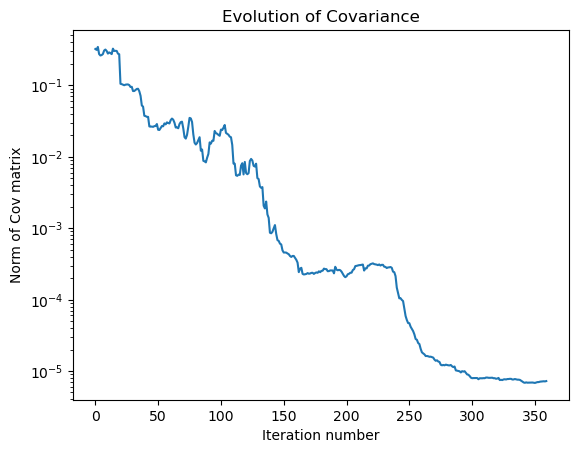

In [70]:
plt.title("Evolution of Covariance")
plt.plot(jax.vmap(jnp.linalg.norm, in_axes=(0))(cov_arr))
plt.xlabel("Iteration number")
plt.ylabel("Norm of Cov matrix")
plt.yscale('log')
plt.show()

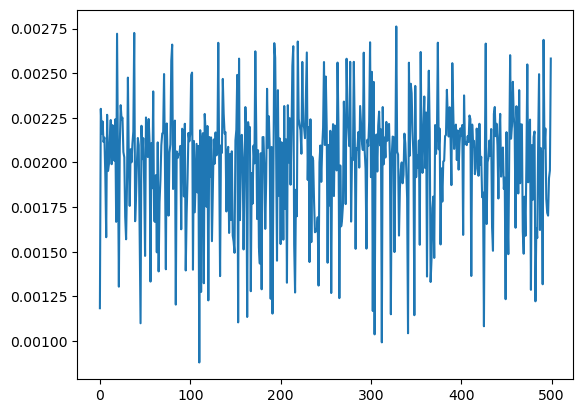

In [40]:
plt.plot(weights)

In [71]:
jnp.diag((est_cov(particles_locations, weights)))

Array([1.3740500e-06, 1.2696255e-06, 1.8998981e-06, 2.3171306e-06,
       1.2130477e-07, 2.7194619e-06, 1.6461127e-07, 2.8591603e-07],      dtype=float32)

In [72]:
est_mean(particles_locations, weights).T

Array([-0.04099951, -0.01788874, -0.11510201, -0.19895479,  0.05654556,
       -0.135969  ,  0.06096783,  0.10835746], dtype=float32)

In [62]:
true_vals

array([-0.127393  , -0.489548  ,  0.000723  , -0.0014456 , -0.00149873,
       -0.02090308,  0.00267172,  0.01134756], dtype=float32)

In [73]:
to_chi_from_super(true_L).round(3)

array([[-0.011+0.j   , -0.003-0.479j, -0.001-0.001j,  0.   -0.j   ],
       [-0.003+0.479j,  0.   +0.j   ,  0.   +0.j   , -0.001-0.001j],
       [-0.001+0.001j,  0.   +0.j   ,  0.   +0.j   , -0.021+0.003j],
       [ 0.   +0.j   , -0.001+0.001j, -0.021-0.003j,  0.011+0.j   ]],
      dtype=complex64)

In [74]:
to_chi_from_super(generate_liouvillian_particle(est_mean(particles_locations, weights), phys_model)).round(3)

array([[-0.108+0.j   , -0.061+0.464j,  0.057+0.23j ,  0.   +0.086j],
       [-0.061-0.464j,  0.   +0.j   ,  0.   +0.j   , -0.199+0.057j],
       [ 0.057-0.23j ,  0.   +0.j   ,  0.   +0.j   , -0.136+0.061j],
       [ 0.   -0.086j, -0.199-0.057j, -0.136-0.061j,  0.108+0.j   ]],
      dtype=complex64)

In [75]:
jnp.linalg.eig(to_chi_from_super(generate_liouvillian_particle(est_mean(particles_locations, weights), phys_model)))

NotImplementedError: Nonsymmetric eigendecomposition is only implemented on the CPU backend. If your matrix is symmetric or Hermitian, you should use eigh instead.

In [81]:
jnp.linalg.eigh(
    to_chi_from_super(true_L)[1:, 1:])[0]

Array([-1.6248913e-02,  1.8502450e-11,  2.7596481e-02], dtype=float32)

In [80]:
jnp.linalg.eigh(
    to_chi_from_super(generate_liouvillian_particle(est_mean(particles_locations, weights), phys_model))[1:, 1:])[0]

Array([-2.0643674e-01,  2.5328812e-09,  3.1479424e-01], dtype=float32)

In [44]:
to_chi_from_super(generate_liouvillian_particle(particles_locations[jnp.argmax(weights)], phys_model)).round(3)

array([[-0.093+0.j   , -0.078+0.481j,  0.066+0.238j,  0.   +0.059j],
       [-0.078-0.481j,  0.   +0.j   ,  0.   +0.j   , -0.218+0.066j],
       [ 0.066-0.238j,  0.   +0.j   ,  0.   +0.j   , -0.155+0.078j],
       [ 0.   -0.059j, -0.218-0.066j, -0.155-0.078j,  0.093+0.j   ]],
      dtype=complex64)